# CS5950/CS4950/CS3950 Course Project

This project recaps and systematises work that has been done in the exercise notebooks: if you have worked through the notebooks, little extra work is required.  The aim of the project is to give you the experience of trying to develop a neural network classifier (or regressor), involving setting up a model, optimising the amount of regularisation, investigating its performance, and devising a new model.

You should do your work in this notebook, filling in the sections below. To do the work, you may re-use code from ***any of the lab-session sheets provided so far***. (In fact, you should be able to do nearly the entire project using code taken from previous lab sessions.)

Please complete this workbook and submit it on Moodle together with answers for other questions, with all outputs (numbers and graphs) visible and included.

Please write your student number **here**: **101004904**    
so that I have an identifier of which worksheet I am marking, to prevent any confusion! (I have to download your notebooks before marking them, so I don't want to accidentally give credit for your notebook to somebody else...)

## Set up dataset

You may choose any of the datasets included with Pytorch, or used in the course so far (including, for example, the percolation data). (It is a free country and you may use any other data you wish.)

A safe choice would be either the MNIST data or the MNIST-fashion data, which is a drop-in replacement for MNIST (same size data format, same number of classes, same number of training and test examples).

A more interesting choice would be CIFAR-10

In setting up the data, you should set up a training set and a test set. The test set should be large enough to give a reasonably accurate assessment of the error-rate (or loss) of your models: preferably at least 10,000 examples.

For the learning curve experiment (below), you will need to construct training sets of different sizes, with the largest at least 10 times the smallest. For the MNIST data, for example, your smallest training set might be 500, with sizes 500, 1000, 2000, 4000, 8000, 16000, 32000, and perhaps 60000 if you have time. (You get no extra marks for doing very long experiments.)

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) # mean and std dev of MNIST dataset

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create indices for subset (first 4000 samples)
indices = list(range(4000))
initial_train_dataset = Subset(train_dataset, indices)

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=initial_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
torch.cuda.is_available()
#finally got cuda to work XD


True

## Set up model

Set up a Pytorch model (you may find it helpful to keep it simple and fast to train). Train on an intermediate-sized dataset (if you are using MNIST, say 2000 or 4000).


Plot the loss and error rate as a function of training epochs.


###  1.  Assessment of initial model:    ***12 marks***

Ensure that your model is complex enough to *overfit* the training data: that is the loss/error-rate on the training set should be below your target loss/error-rate, and the loss/error-rate on the validation set should be higher than this (preferably higher than your target error-rate).

In [4]:
class NN1(nn.Module):
    def __init__(self):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64,10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.relu(self.fc4(x))
        x = self.fc5(x)
        return x


model = NN1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, criterion, optimizer, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    device = next(model.parameters()).device

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def evaulate(model,criterion,test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    device = next(model.parameters()).device

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
#train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

n_epochs = 30
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    test_loss, test_acc = evaulate(model, criterion, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f'Epoch: {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')



Epoch: 1 Train Loss: 0.9867 Train Acc: 0.6970 Test Loss: 0.5063 Test Acc: 0.8322
Epoch: 2 Train Loss: 0.3162 Train Acc: 0.9042 Test Loss: 0.3614 Test Acc: 0.8824
Epoch: 3 Train Loss: 0.2240 Train Acc: 0.9285 Test Loss: 0.2894 Test Acc: 0.9096
Epoch: 4 Train Loss: 0.1424 Train Acc: 0.9573 Test Loss: 0.2617 Test Acc: 0.9214
Epoch: 5 Train Loss: 0.1206 Train Acc: 0.9610 Test Loss: 0.2520 Test Acc: 0.9213
Epoch: 6 Train Loss: 0.0748 Train Acc: 0.9775 Test Loss: 0.2641 Test Acc: 0.9254
Epoch: 7 Train Loss: 0.0408 Train Acc: 0.9895 Test Loss: 0.2543 Test Acc: 0.9322
Epoch: 8 Train Loss: 0.0423 Train Acc: 0.9870 Test Loss: 0.2555 Test Acc: 0.9314
Epoch: 9 Train Loss: 0.0241 Train Acc: 0.9942 Test Loss: 0.2654 Test Acc: 0.9322
Epoch: 10 Train Loss: 0.0114 Train Acc: 0.9982 Test Loss: 0.2985 Test Acc: 0.9349
Epoch: 11 Train Loss: 0.0155 Train Acc: 0.9958 Test Loss: 0.3327 Test Acc: 0.9243
Epoch: 12 Train Loss: 0.0256 Train Acc: 0.9912 Test Loss: 0.3516 Test Acc: 0.9204
Epoch: 13 Train Loss: 0.0

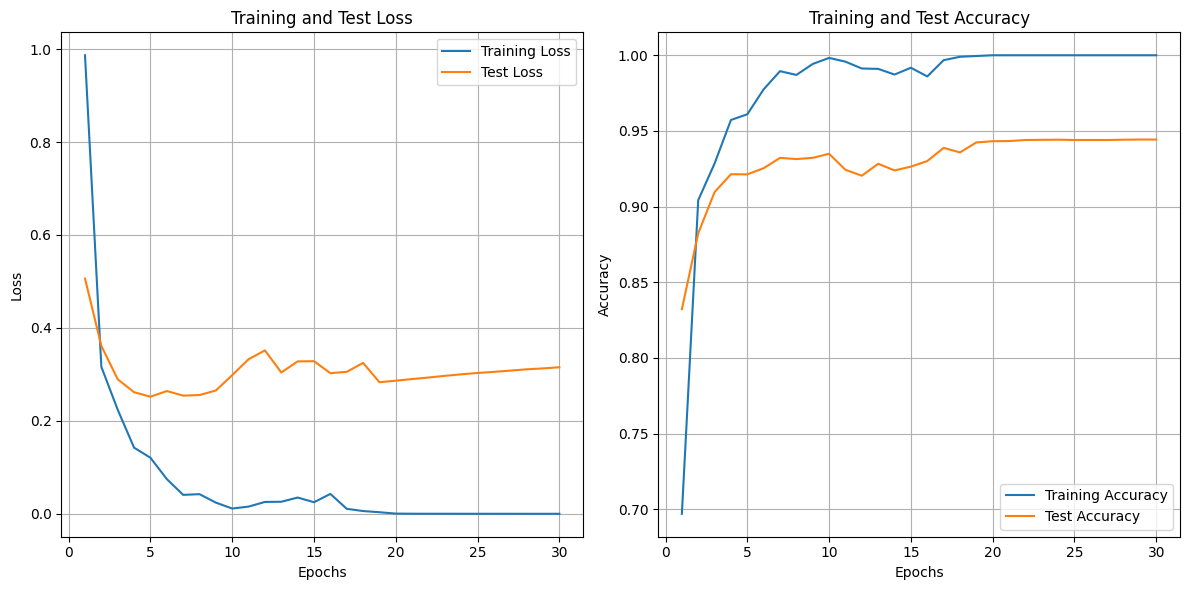


Assessment of Initial Model:
Final Training Loss: 0.0001, Accuracy: 1.0000
Final Test Loss: 0.3153, Accuracy: 0.9443
Model shows signs of overfitting as training accuracy is higher than test accuracy.
Overfitting gap: 0.0557


In [ ]:

plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Test Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Training and Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# check if the model is overfitting
final_train_loss, final_train_acc = train_losses[-1], train_accuracies[-1]
final_test_loss, final_test_acc = test_losses[-1], test_accuracies[-1]

print("\nAssessment of Initial Model:")
print(f"Final Training Loss: {final_train_loss:.4f}, Accuracy: {final_train_acc:.4f}")
print(f"Final Test Loss: {final_test_loss:.4f}, Accuracy: {final_test_acc:.4f}")

if final_train_acc > final_test_acc:
    print("Model shows signs of overfitting as training accuracy is higher than test accuracy.")
    overfitting_gap = final_train_acc - final_test_acc
    print(f"Overfitting gap: {overfitting_gap:.4f}")
else:
    print("Model does not show clear signs of overfitting yet.")

### 2.  Regularisation experiment:  ***12 marks***

Now select a type of regularisation (which may be L2, or dropout) and train your initial model with different amounts of regularisation.

A small amount of regularisation may improve the validation set performance of your overfitted model; too much regularisation may make performance on the validation set worse.

Train your model multiple times, applying different amounts of regularisation, and plot a graoph showing the effect of different amounts of regularisation.

Plot the amount of regularisation along the x axis, and the validation set performance (loss/error-rate) on the y axis.  How does regularisation affect the performance of your initial network, and what is the optimal amount?

In [12]:
class NN1WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(NN1WithDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc5 = nn.Linear(64,10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.dropout1(nn.functional.relu(self.fc1(x)))
        x = self.dropout2(nn.functional.relu(self.fc2(x)))
        x = self.dropout3(nn.functional.relu(self.fc3(x)))
        x = self.dropout4(nn.functional.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

def evaluate(model, criterion, test_loader):
    model.eval()  
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    test_loss /= len(test_loader)
    test_acc = correct / total
    return test_loss, test_acc


def train(model, criterion, optimizer, train_loader):
    model.train()  
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

Dropout Rate: 0.0, Test Loss: 0.3562, Test Accuracy: 0.9475
Dropout Rate: 0.1, Test Loss: 0.3208, Test Accuracy: 0.9388
Dropout Rate: 0.2, Test Loss: 0.3591, Test Accuracy: 0.9346
Dropout Rate: 0.3, Test Loss: 0.3000, Test Accuracy: 0.9429
Dropout Rate: 0.4, Test Loss: 0.2811, Test Accuracy: 0.9444
Dropout Rate: 0.5, Test Loss: 0.2732, Test Accuracy: 0.9456
Dropout Rate: 0.6, Test Loss: 0.3073, Test Accuracy: 0.9384
Dropout Rate: 0.7, Test Loss: 0.4477, Test Accuracy: 0.9036


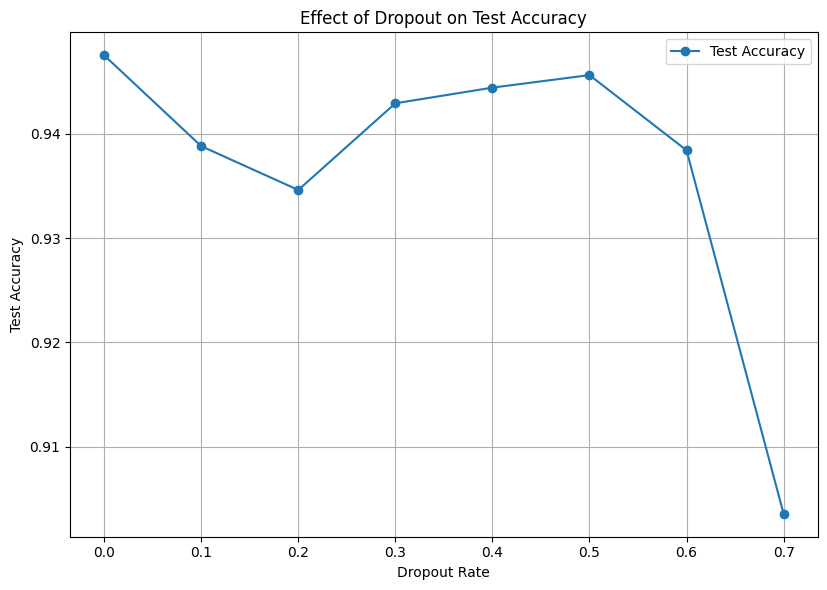

Best test accuracy with dropout: 0.9475


In [18]:

# Test different dropout rates
dropout_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
test_accuracies_dropout = []
test_losses_dropout = []

n_epochs = 30
for rate in dropout_rates:
    model = NN1WithDropout(dropout_rate=rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # train for the same number of epochs
    for epoch in range(n_epochs):
        train(model, criterion, optimizer, train_loader)
    
    # eval 
    test_loss, test_acc = evaulate(model, criterion, test_loader)
    test_losses_dropout.append(test_loss)
    test_accuracies_dropout.append(test_acc)
    
    print(f'Dropout Rate: {rate:.1f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# plot the effect of dropout on test accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
plt.plot(dropout_rates, test_accuracies_dropout, 'o-', label='Test Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Test Accuracy')
plt.title('Effect of Dropout on Test Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

best_dropout_acc = max(test_accuracies_dropout)
print(f"Best test accuracy with dropout: {best_dropout_acc:.4f}")

Best loss with dropout:  0.27317280869213906
Best dropout rate:  0.5


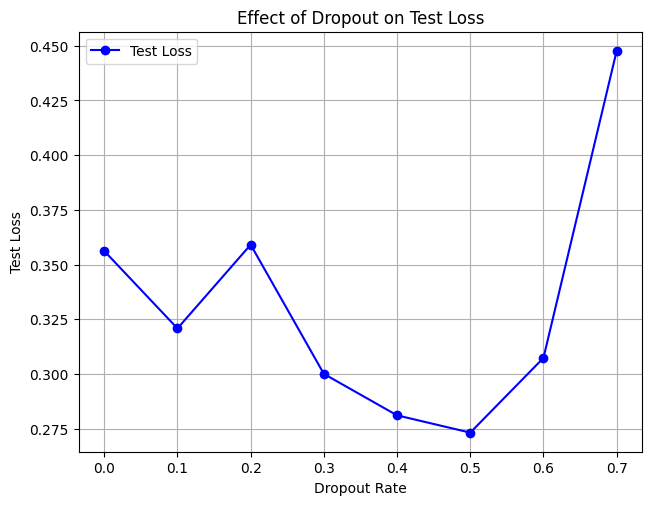

In [19]:
plt.figure(figsize=(16, 12))

# plot dropout effect on test loss
plt.subplot(2, 2, 1)
plt.plot(dropout_rates, test_losses_dropout, 'o-', color='blue', label='Test Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Test Loss')
plt.title('Effect of Dropout on Test Loss')
plt.grid(True)
plt.legend()

print("Best loss with dropout: ", min(test_losses_dropout))
print("Best dropout rate: ", dropout_rates[test_losses_dropout.index(min(test_losses_dropout))])

### 3.  Learning curve experiment:  ***12 marks***

Now train your model (with the amount of regularisation you selected) on different amounts of training data.

Plot the performance (loss/error-rate) of the model on the validation set against the size of the training set.
This is typically best done on a log-log plot.

Describe the approximate relationship between the training set size and loss / error-rate.  Does the network performance appear to improve as some power of the amount of data in the training set?  If so, by what power ?

For example, a very good rate of improvement is for error-rate to be proportional to $\dfrac{1}{\sqrt{n}}$ where $n$ is the training set size.  For your model, the rate of improvement of validation error with training set size may not be as fast as this (or it may, who knows?)  The aim of this exercise is to find out what it actually is.


Training with 500 samples...
Epoch 5/30, Train Loss: 1.8143
Epoch 10/30, Train Loss: 1.0925
Epoch 15/30, Train Loss: 0.5638
Epoch 20/30, Train Loss: 0.3122
Epoch 25/30, Train Loss: 0.2190
Epoch 30/30, Train Loss: 0.1305
Training Size: 500, Test Loss: 0.7617, Test Accuracy: 0.8444, Error Rate: 0.1556

Training with 1000 samples...
Epoch 5/30, Train Loss: 1.2323
Epoch 10/30, Train Loss: 0.5654
Epoch 15/30, Train Loss: 0.3475
Epoch 20/30, Train Loss: 0.1742
Epoch 25/30, Train Loss: 0.1170
Epoch 30/30, Train Loss: 0.1170
Training Size: 1000, Test Loss: 0.5484, Test Accuracy: 0.8951, Error Rate: 0.1049

Training with 2000 samples...
Epoch 5/30, Train Loss: 0.7662
Epoch 10/30, Train Loss: 0.3307
Epoch 15/30, Train Loss: 0.2562
Epoch 20/30, Train Loss: 0.1693
Epoch 25/30, Train Loss: 0.1302
Epoch 30/30, Train Loss: 0.1409
Training Size: 2000, Test Loss: 0.3785, Test Accuracy: 0.9199, Error Rate: 0.0801

Training with 4000 samples...
Epoch 5/30, Train Loss: 0.4464
Epoch 10/30, Train Loss: 0.2

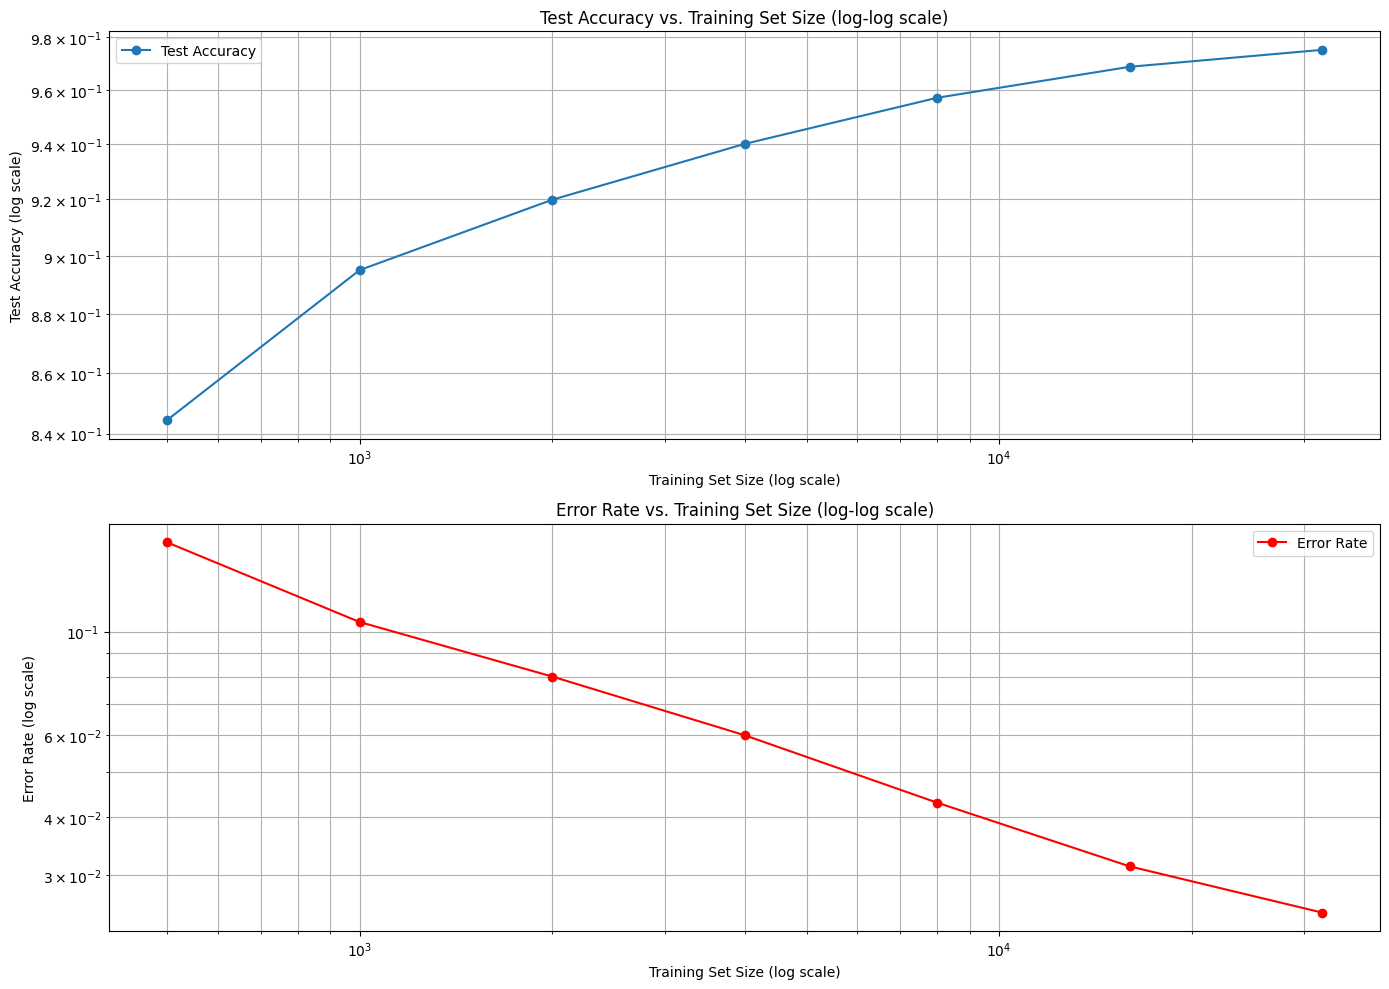


Power law relationship: Error Rate ≈ 2.2860 × (Training Size)^(-0.4400)
For reference, Error Rate ~ 1/√n would give an exponent of -0.5


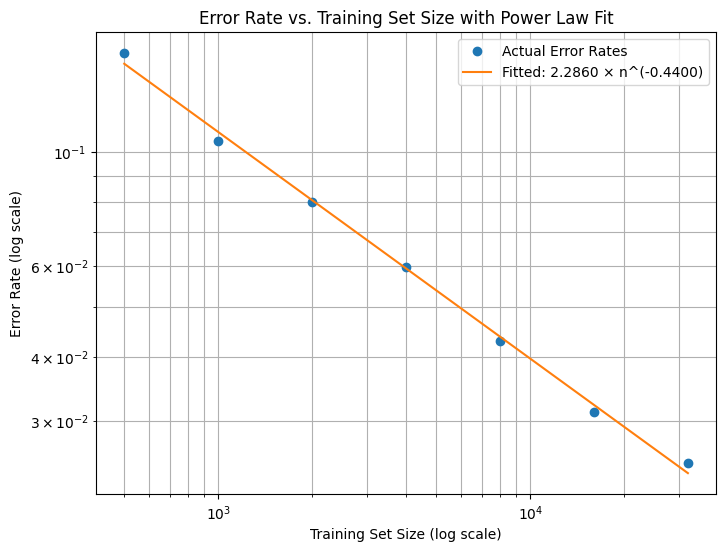

In [22]:
train_sizes = [500, 1000, 2000, 4000, 8000, 16000, 32000]


test_losses = []
test_accuracies = []
error_rates = [] 

# set the optimal dropout rate based on our previous experiment
optimal_dropout = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 30  


for size in train_sizes:
    print(f"\nTraining with {size} samples...")
    
    # Create subset of training data
    indices = list(range(size))
    train_subset = Subset(train_dataset, indices)
    subset_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
    
    model = NN1WithDropout(dropout_rate=optimal_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # train model
    for epoch in range(n_epochs):
        train_loss = train(model, criterion, optimizer, subset_loader)
        if epoch % 5 == 4:  # Print every 5 epochs
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}')
    
    # evaluate on test set
    test_loss, test_acc = evaluate(model, criterion, test_loader)
    error_rate = 1 - test_acc
    
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    error_rates.append(error_rate)
    
    print(f'Training Size: {size}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Error Rate: {error_rate:.4f}')


plt.figure(figsize=(14, 10))

# Plot test accuracy vs training size (log-log)
plt.subplot(2, 1, 1)
plt.loglog(train_sizes, test_accuracies, 'o-', label='Test Accuracy')
plt.xlabel('Training Set Size (log scale)')
plt.ylabel('Test Accuracy (log scale)')
plt.title('Test Accuracy vs. Training Set Size (log-log scale)')
plt.grid(True, which="both", ls="-")
plt.legend()

# Plot error rate vs training size (log-log)
plt.subplot(2, 1, 2)
plt.loglog(train_sizes, error_rates, 'o-', color='red', label='Error Rate')
plt.xlabel('Training Set Size (log scale)')
plt.ylabel('Error Rate (log scale)')
plt.title('Error Rate vs. Training Set Size (log-log scale)')
plt.grid(True, which="both", ls="-")
plt.legend()

plt.tight_layout()
plt.show()

# fit a power law to see relationship (Error ~ n^α)
log_sizes = np.log(train_sizes)
log_errors = np.log(error_rates)

# Linear regression on log-log data
coeffs = np.polyfit(log_sizes, log_errors, 1)
alpha = coeffs[0]  #  power law exponent
constant = np.exp(coeffs[1])

print(f"\nPower law relationship: Error Rate ≈ {constant:.4f} × (Training Size)^({alpha:.4f})")
print(f"For reference, Error Rate ~ 1/√n would give an exponent of -0.5")

predicted_errors = constant * np.array(train_sizes) ** alpha
plt.figure(figsize=(8, 6))
plt.loglog(train_sizes, error_rates, 'o', label='Actual Error Rates')
plt.loglog(train_sizes, predicted_errors, '-', label=f'Fitted: {constant:.4f} × n^({alpha:.4f})')
plt.xlabel('Training Set Size (log scale)')
plt.ylabel('Error Rate (log scale)')
plt.title('Error Rate vs. Training Set Size with Power Law Fit')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

### 4. Second model:   *** 14 marks ***

Devise what you believe to be a better neural network architecture for the problem (e.g. for MNIST you might use a fully-connected network for your initial model, and then try a convolutional net for your second model).

Repeat sections 2 (regularisation experiment), and determine whether it has better validation set performance than the first model, for an intermediate size of training set (e.g. 2000 or 4000 for the MNIST data).

Repeat section 3. Does your model have a different learning curve from the first? Plot the learning curves for the first and second model on the same graph, to compare them. Comment: is there a more rapid reduction of error-rate with training set size for your second model?  

In [9]:
class NN2(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(NN2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        
        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)     
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # after pooling, the image is 7x7
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)          
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  
        x = self.dropout1(x)
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))  
        x = self.dropout2(x)
        
        x = x.view(-1, 64 * 7 * 7)
        
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)  
        
        return x

In [20]:
#test different dropout rates with CNN model
dropout_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
test_losses_cnn_dropout = []
test_accuracies_cnn_dropout = []

for rate in dropout_rates:
    model_cnn = NN2(dropout_rate=rate).to(device)
    optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
    
    # Train for the same number of epochs
    for epoch in range(30):
        train(model_cnn, criterion, optimizer, train_loader)
    
    # Evaluate
    test_loss, test_acc = evaluate(model_cnn, criterion, test_loader)
    test_losses_cnn_dropout.append(test_loss)
    test_accuracies_cnn_dropout.append(test_acc)
    
    print(f'CNN Model - Dropout Rate: {rate:.1f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')




CNN Model - Dropout Rate: 0.0, Test Loss: 0.1187, Test Accuracy: 0.9736
CNN Model - Dropout Rate: 0.1, Test Loss: 0.1031, Test Accuracy: 0.9765
CNN Model - Dropout Rate: 0.2, Test Loss: 0.0956, Test Accuracy: 0.9700
CNN Model - Dropout Rate: 0.3, Test Loss: 0.0830, Test Accuracy: 0.9760
CNN Model - Dropout Rate: 0.4, Test Loss: 0.0797, Test Accuracy: 0.9778
CNN Model - Dropout Rate: 0.5, Test Loss: 0.0941, Test Accuracy: 0.9723
CNN Model - Dropout Rate: 0.6, Test Loss: 0.0676, Test Accuracy: 0.9776
CNN Model - Dropout Rate: 0.7, Test Loss: 0.0777, Test Accuracy: 0.9738


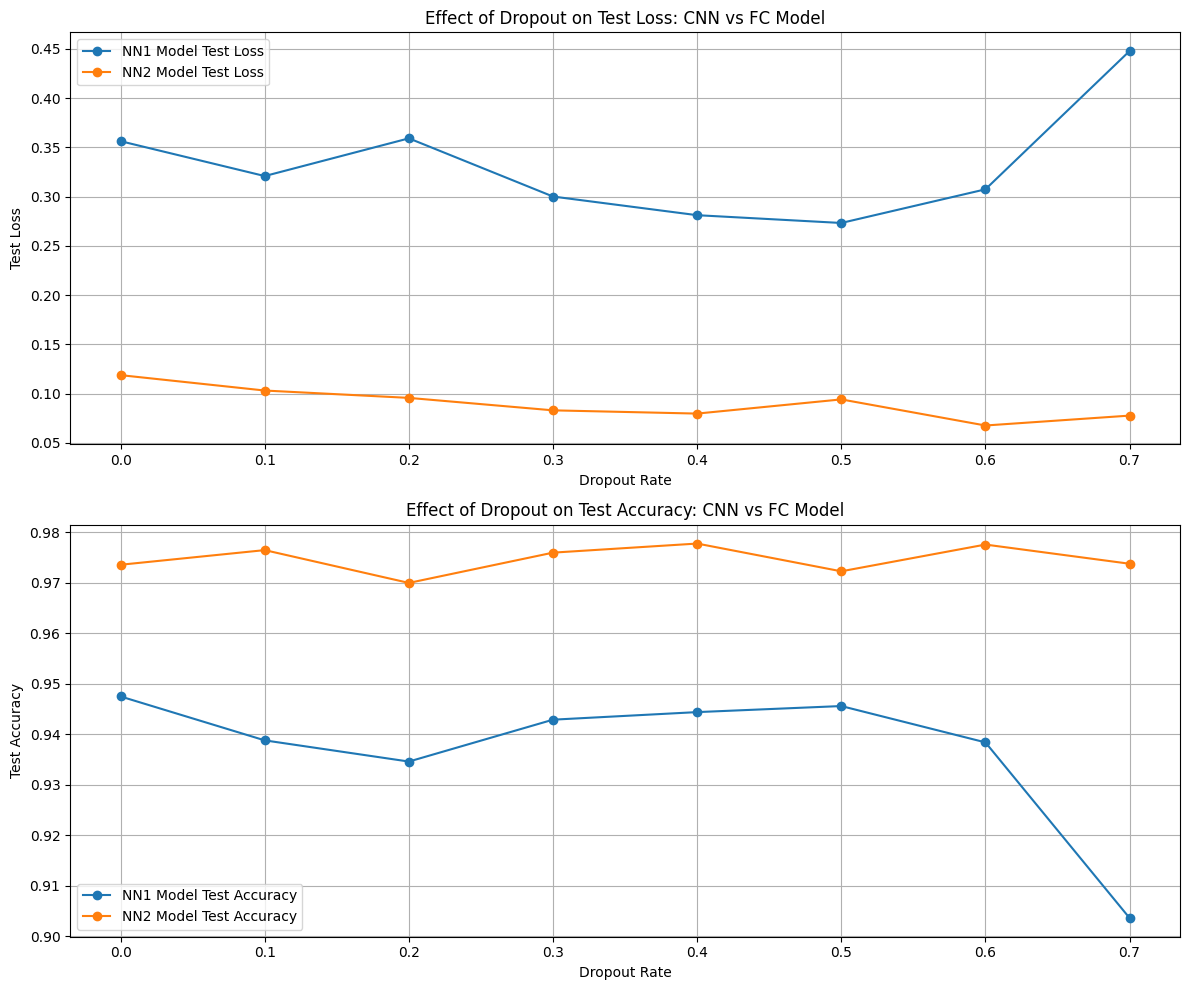

Best dropout rate for CNN model: 0.4
Best test accuracy with CNN model: 0.9778
Compared to FC model best accuracy: 0.9475


In [25]:
# compare CNN and fully connected models with different dropout rates
plt.figure(figsize=(12, 10))

# Plot loss comparison
plt.subplot(2, 1, 1)
plt.plot(dropout_rates, test_losses_dropout, 'o-', label='NN1 Model Test Loss')
plt.plot(dropout_rates, test_losses_cnn_dropout, 'o-', label='NN2 Model Test Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Test Loss')
plt.title('Effect of Dropout on Test Loss: CNN vs FC Model')
plt.grid(True)
plt.legend()

# Plot accuracy comparison
plt.subplot(2, 1, 2)
plt.plot(dropout_rates, test_accuracies_dropout, 'o-', label='NN1 Model Test Accuracy')
plt.plot(dropout_rates, test_accuracies_cnn_dropout, 'o-', label='NN2 Model Test Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Test Accuracy')
plt.title('Effect of Dropout on Test Accuracy: CNN vs FC Model')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# find the best dropout rate for CNN model
best_dropout_idx = test_accuracies_cnn_dropout.index(max(test_accuracies_cnn_dropout))
best_dropout_rate_cnn = dropout_rates[best_dropout_idx]
print(f"Best dropout rate for CNN model: {best_dropout_rate_cnn}")
print(f"Best test accuracy with CNN model: {max(test_accuracies_cnn_dropout):.4f}")
print(f"Compared to FC model best accuracy: {max(test_accuracies_dropout):.4f}")

In [23]:
cnn_test_losses = []
cnn_test_accuracies = []
cnn_error_rates = [] 

# set the optimal dropout rate based on our previous experiment
optimal_dropout = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 30  


for size in train_sizes:
    print(f"\nTraining with {size} samples...")
    
    # Create subset of training data
    indices = list(range(size))
    train_subset = Subset(train_dataset, indices)
    subset_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
    
    model = NN2(dropout_rate=optimal_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # train model
    for epoch in range(n_epochs):
        train_loss = train(model, criterion, optimizer, subset_loader)
        if epoch % 5 == 4:  # Print every 5 epochs
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}')
    
    # evaluate on test set
    test_loss, test_acc = evaluate(model, criterion, test_loader)
    error_rate = 1 - test_acc
    
    cnn_test_losses.append(test_loss)
    cnn_test_accuracies.append(test_acc)
    cnn_error_rates.append(error_rate)
    
    print(f'Training Size: {size}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Error Rate: {error_rate:.4f}')



Training with 500 samples...
Epoch 5/30, Train Loss: 0.6060
Epoch 10/30, Train Loss: 0.3006
Epoch 15/30, Train Loss: 0.1952
Epoch 20/30, Train Loss: 0.0920
Epoch 25/30, Train Loss: 0.0920
Epoch 30/30, Train Loss: 0.0677
Training Size: 500, Test Loss: 0.3915, Test Accuracy: 0.8990, Error Rate: 0.1010

Training with 1000 samples...
Epoch 5/30, Train Loss: 0.4450
Epoch 10/30, Train Loss: 0.2133
Epoch 15/30, Train Loss: 0.1586
Epoch 20/30, Train Loss: 0.1113
Epoch 25/30, Train Loss: 0.0585
Epoch 30/30, Train Loss: 0.0340
Training Size: 1000, Test Loss: 0.2175, Test Accuracy: 0.9360, Error Rate: 0.0640

Training with 2000 samples...
Epoch 5/30, Train Loss: 0.2513
Epoch 10/30, Train Loss: 0.1303
Epoch 15/30, Train Loss: 0.0705
Epoch 20/30, Train Loss: 0.0646
Epoch 25/30, Train Loss: 0.0492
Epoch 30/30, Train Loss: 0.0328
Training Size: 2000, Test Loss: 0.1296, Test Accuracy: 0.9627, Error Rate: 0.0373

Training with 4000 samples...
Epoch 5/30, Train Loss: 0.1830
Epoch 10/30, Train Loss: 0.1

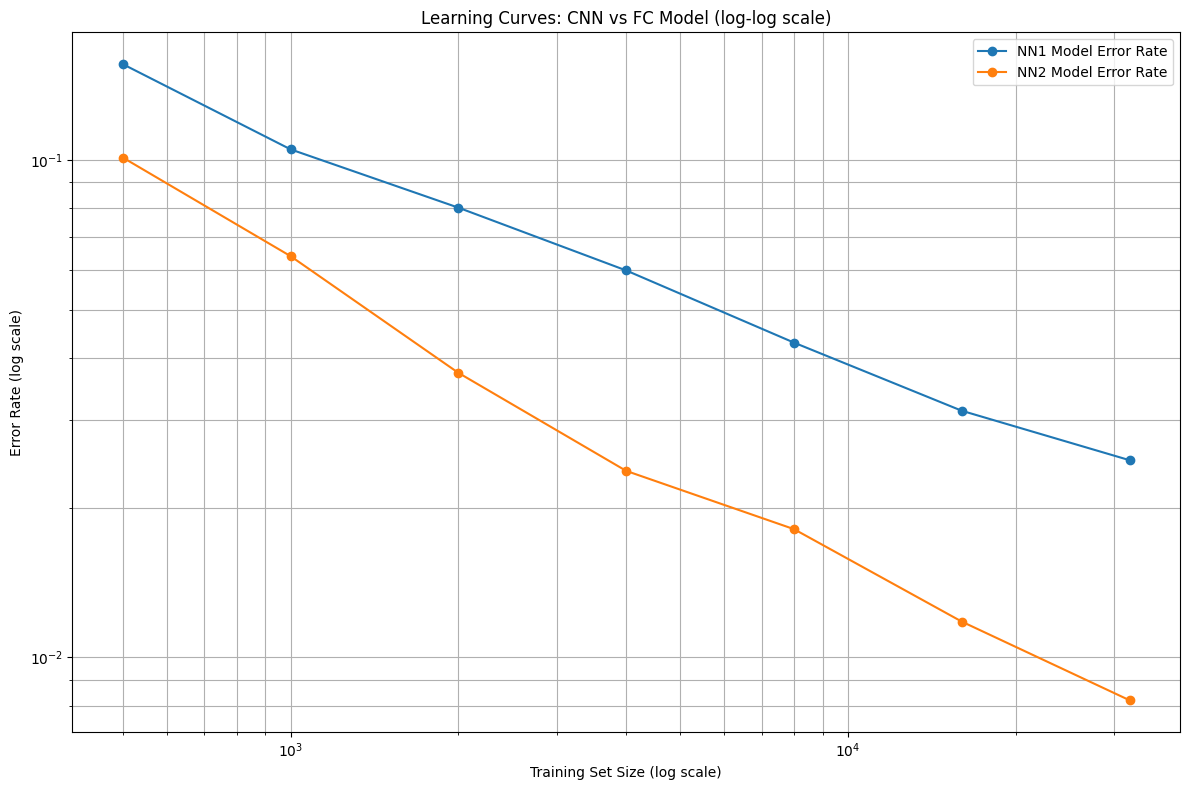


Power law relationship for FC Model: Error Rate ≈ 2.2860 × (Training Size)^(-0.4400)
Power law relationship for CNN Model: Error Rate ≈ 3.8771 × (Training Size)^(-0.5996)


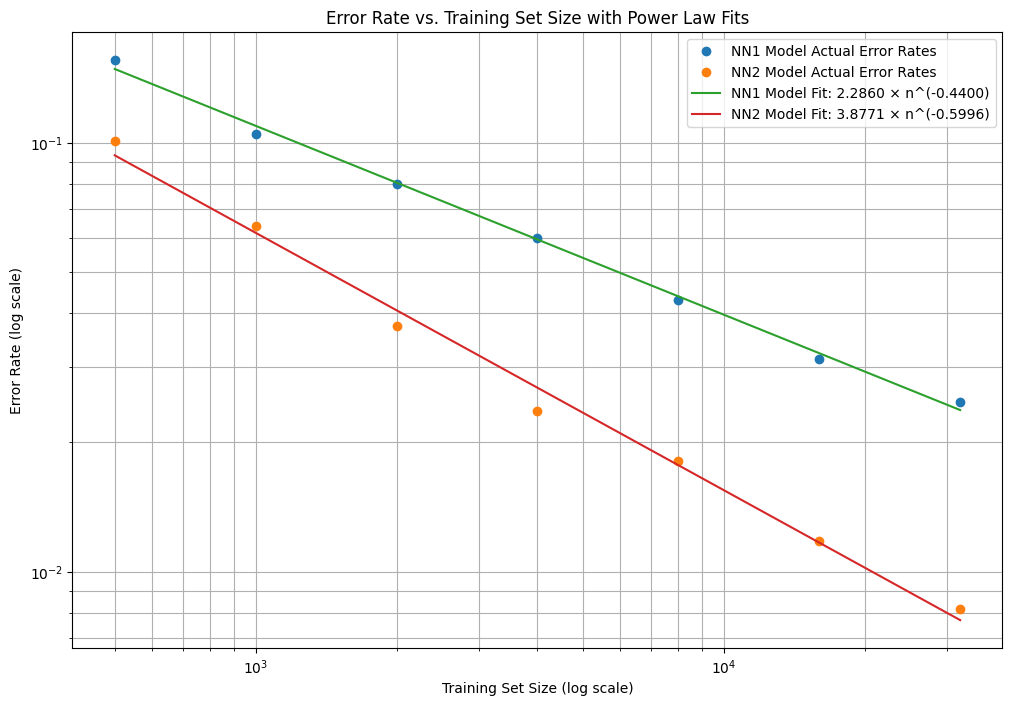

In [26]:
plt.figure(figsize=(12, 8))

# Plot error rates (log-log)
plt.loglog(train_sizes, error_rates, 'o-', label='NN1 Model Error Rate')
plt.loglog(train_sizes, cnn_error_rates, 'o-', label='NN2 Model Error Rate')
plt.xlabel('Training Set Size (log scale)')
plt.ylabel('Error Rate (log scale)')
plt.title('Learning Curves: CNN vs FC Model (log-log scale)')
plt.grid(True, which="both", ls="-")
plt.legend()

plt.tight_layout()
plt.show()

# Fit power laws to both models
log_sizes = np.log(train_sizes)
log_fc_errors = np.log(error_rates)
log_cnn_errors = np.log(cnn_error_rates)

# Linear regression on log-log data
fc_coeffs = np.polyfit(log_sizes, log_fc_errors, 1)
cnn_coeffs = np.polyfit(log_sizes, log_cnn_errors, 1)

fc_alpha = fc_coeffs[0]  # power law exponent for FC
cnn_alpha = cnn_coeffs[0]  # power law exponent for CNN
fc_constant = np.exp(fc_coeffs[1])
cnn_constant = np.exp(cnn_coeffs[1])

print(f"\nPower law relationship for FC Model: Error Rate ≈ {fc_constant:.4f} × (Training Size)^({fc_alpha:.4f})")
print(f"Power law relationship for CNN Model: Error Rate ≈ {cnn_constant:.4f} × (Training Size)^({cnn_alpha:.4f})")

# Plot with fitted curves
plt.figure(figsize=(12, 8))
plt.loglog(train_sizes, error_rates, 'o', label='NN1 Model Actual Error Rates')
plt.loglog(train_sizes, cnn_error_rates, 'o', label='NN2 Model Actual Error Rates')

# Predicted values based on power law fits
fc_predicted = fc_constant * np.array(train_sizes) ** fc_alpha
cnn_predicted = cnn_constant * np.array(train_sizes) ** cnn_alpha

plt.loglog(train_sizes, fc_predicted, '-', label=f'NN1 Model Fit: {fc_constant:.4f} × n^({fc_alpha:.4f})')
plt.loglog(train_sizes, cnn_predicted, '-', label=f'NN2 Model Fit: {cnn_constant:.4f} × n^({cnn_alpha:.4f})')

plt.xlabel('Training Set Size (log scale)')
plt.ylabel('Error Rate (log scale)')
plt.title('Error Rate vs. Training Set Size with Power Law Fits')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

To conclude, the learning gradients were quite similar but NN2, using a CNN was far superior overall (99% accuracy!)